In [54]:
library(ggplot2)
library(dplyr)
library(ggalluvial)
library(ggbump)

In [38]:
fig.size <- function (height, width) {
    options(repr.plot.height = height, repr.plot.width = width)
}
     


In [3]:
res = read.csv('Tumor_ST_lr_pairs.csv')

In [9]:
res %>% dim

[1] 616  11

In [16]:
lr_df = read.csv(
    '/n/fs/ragr-research/users/hirak/Projects/copulacci/src/copulacci/_data/LRdatabase/SpatialDM/human_lr_pairs.csv'
)

In [17]:
lr_df_merged = merge(res, lr_df, by = 'X')

In [25]:
lr_df_merged %>% filter(ligand == 'ANGPTL2')

X,copula_coeff,mu_x,mu_y,copula_method,copula_pval,scc,scc_pval,global_I,global_pval,copula_pval_fdr,ligand,receptor
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
ANGPTL2_ITGA5_ITGB1,0.1159459,-11.48913,-8.049851,copula,0.02594810,0.02940588,0.5968064,-0.03581399,1,0.2157467,ANGPTL2,ITGA5_ITGB1
ANGPTL2_PIRB,0.1833333,-11.48913,-11.577548,copula,0.46630728,-0.08256366,0.1177645,-0.08772303,1,0.7734209,ANGPTL2,LILRB3
ANGPTL2_TLR4,0.3795495,-11.48913,-10.873101,copula,0.01054852,-0.01270327,0.8283433,-0.02233362,1,0.1584851,ANGPTL2,TLR4


In [86]:
tmp.subset = lr_df_merged %>% filter(ligand %in% c('WNT9A', 'ANGPTL2') )

In [294]:
library(ggrepel)

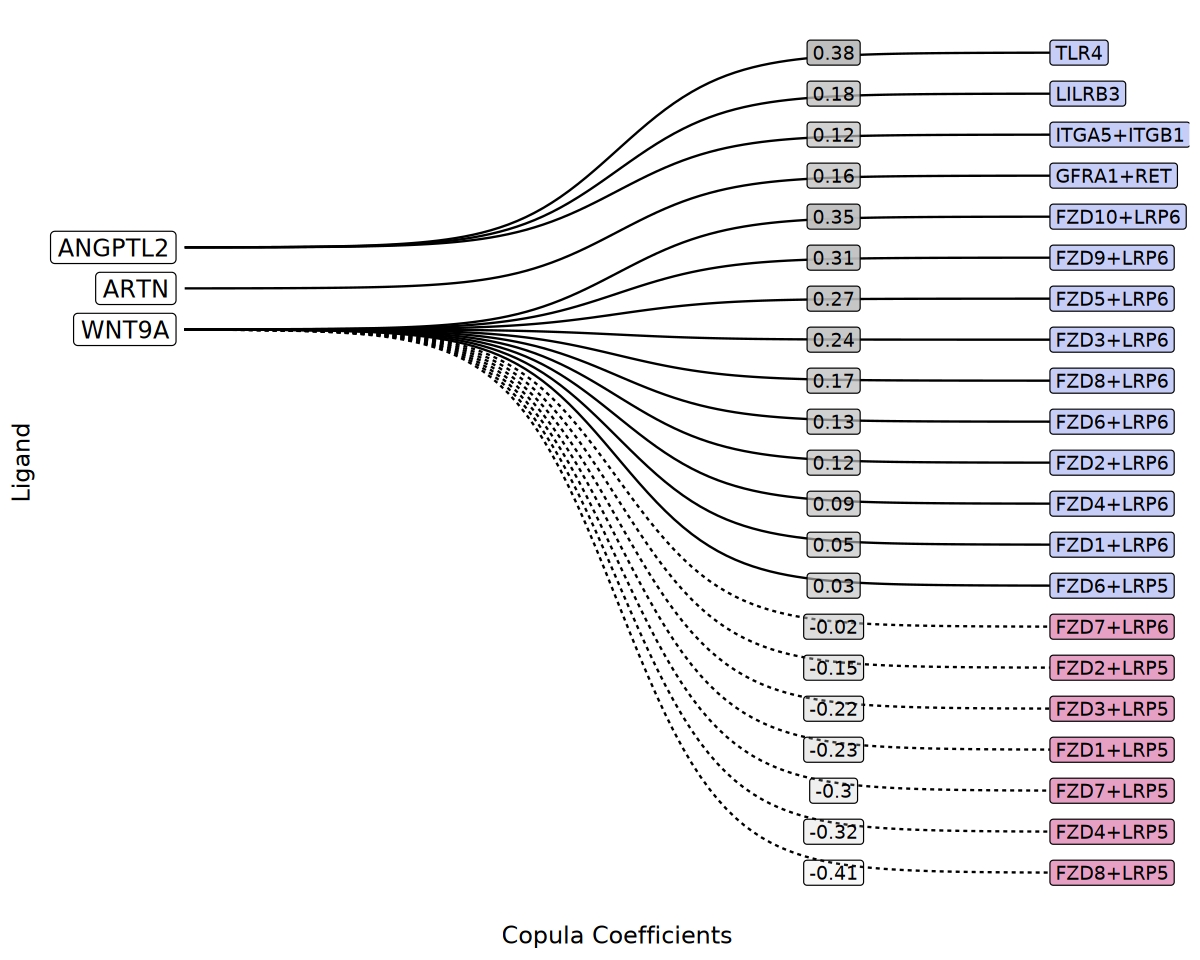

In [409]:
tmp.subset = lr_df_merged %>% filter(ligand %in% c('WNT9A','ARTN', 'ANGPTL2') )
tmp.subset = tmp.subset |> arrange(ligand,desc(copula_coeff))

to_nodes = distinct(tmp.subset, receptor) |> mutate(to_y = row_number())
num_senders = (distinct(tmp.subset, ligand) %>% dim)[[1]]
from_nodes = distinct(tmp.subset, ligand) |> mutate(from_y = round(dim(to_nodes)[[1]])/(num_senders+1) + row_number()-1+0.5)

fig.size(8,10)

df = tmp.subset |> arrange(desc(copula_coeff)) |>
    ## generate mapping type/case variables
    group_by(ligand) |>
    mutate(n_dest = n()) |>
    ungroup() |>
    group_by(receptor) |>
    mutate(n_origin = n(),
           min_weight = min(copula_coeff)) |>
    ungroup() |>
    mutate(value_case = case_when(copula_coeff <= 0 ~ "negative",
                                  copula_coeff > 0 ~ "positive")) |>
    left_join(tribble(~value_case, ~line_type, ~font_type,
                      "positive", "solid", "bold",
                      "negative", "dashed", "italic"),
              by = "value_case") |>
    left_join(from_nodes, by = "ligand") |>
    left_join(to_nodes, by = "receptor") |>
    ## add x-coordinates
    mutate(from_x = 0,
           to_x = 10) |>
    ## give each from-out instruction a unique id
    mutate(receptor = gsub("_","+", receptor)) |>
    mutate(idx = row_number())

df |>
    ggplot(aes(x = from_x , xend = to_x, y = from_y, yend = to_y, group = idx)) +
    ## edges as sigmoid curves with line type
    geom_sigmoid(aes(linetype = I(line_type))) +
    # to/from nodes
    scale_y_reverse() +
    geom_label(
        data = df %>% distinct(ligand, .keep_all = TRUE),
        aes(
        x = from_x-0.1, 
        label=ligand),size=5,hjust = 1) +
    #geom_label(aes(x = from_x - 0.5, y = to_y, label=receptor),hjust = 1) +
    geom_label(aes(x = to_x , y = to_y, label=receptor, fill = value_case),hjust = 0) +
    # edge labels
    geom_label(data = df,
               aes(x = (((from_x + to_x) / 2) + to_x) / 2,
                   y = to_y,
                   label = round(copula_coeff,2),
                   alpha = copula_coeff),
               fill = "gray") +
    scale_fill_manual(values = wesanderson::wes_palette(n = 4, name = "GrandBudapest2")) +
    scale_color_manual(values = wesanderson::wes_palette(n = 4, name = "GrandBudapest2")) +
    cowplot::theme_minimal_grid(font_size = 14, line_size = 0) +
    theme(legend.position = "none",
          panel.grid.major = element_blank(),
          axis.text.y = element_blank(),
          axis.text.x = element_blank()
        ) +
    scale_x_continuous(limits = c(-1, 11)) +
    labs(x = "Copula Coefficients", y = 'Ligand', fill = "Target", fontface="Source") 

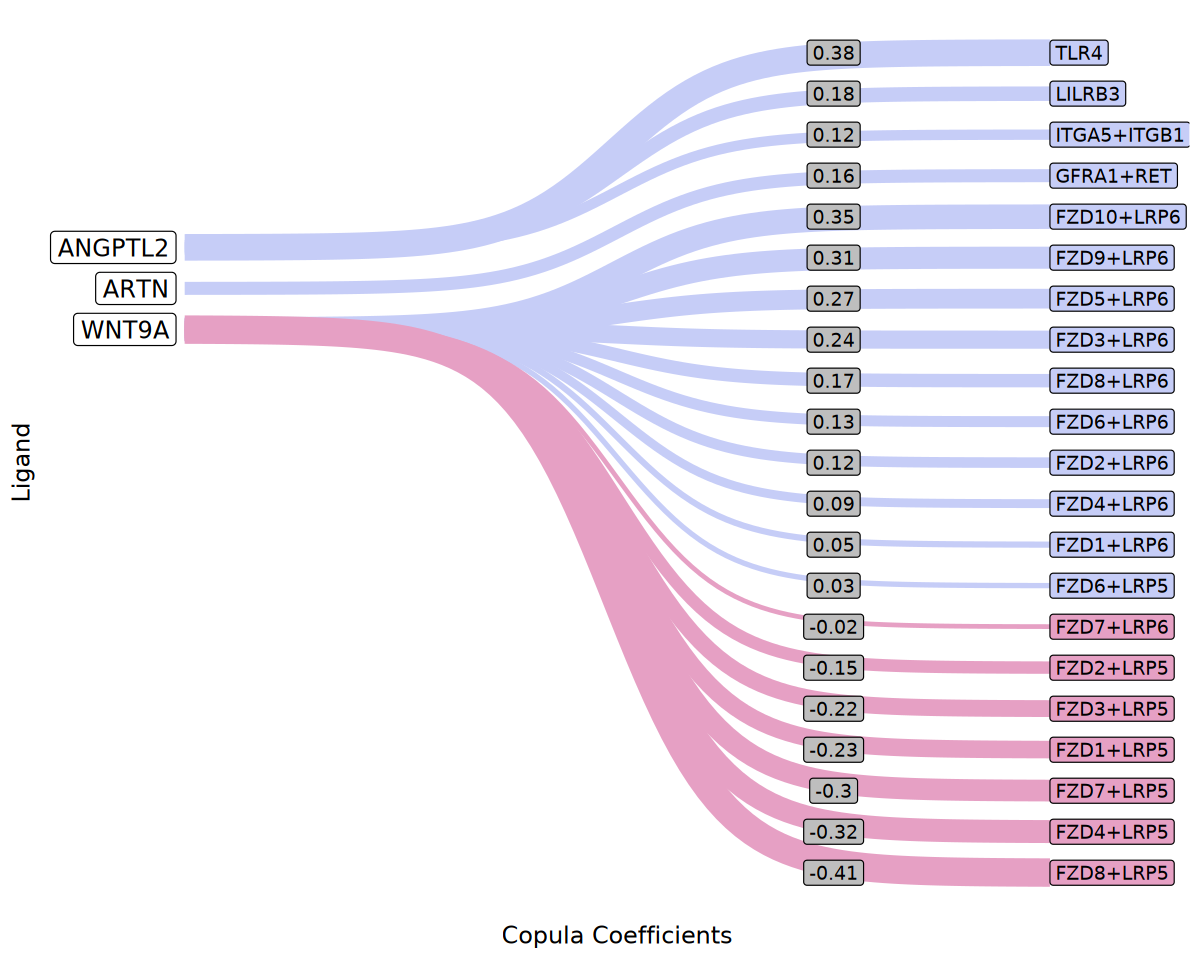

In [410]:
tmp.subset = lr_df_merged %>% filter(ligand %in% c('WNT9A','ARTN', 'ANGPTL2') )
tmp.subset = tmp.subset |> arrange(ligand,desc(copula_coeff))

to_nodes = distinct(tmp.subset, receptor) |> mutate(to_y = row_number())
num_senders = (distinct(tmp.subset, ligand) %>% dim)[[1]]
from_nodes = distinct(tmp.subset, ligand) |> mutate(from_y = round(dim(to_nodes)[[1]])/(num_senders+1) + row_number()-1+0.5)

fig.size(8,10)

df = tmp.subset |> arrange(desc(copula_coeff)) |>
    ## generate mapping type/case variables
    group_by(ligand) |>
    mutate(n_dest = n()) |>
    ungroup() |>
    group_by(receptor) |>
    mutate(n_origin = n(),
           min_weight = min(copula_coeff)) |>
    ungroup() |>
    mutate(value_case = case_when(copula_coeff <= 0 ~ "negative",
                                  copula_coeff > 0 ~ "positive")) |>
    left_join(tribble(~value_case, ~line_type, ~font_type, ~line_color,
                      "positive", "solid", "bold", "#E6A0C4",
                      "negative", "dashed", "italic", "#C6CDF7"),
              by = "value_case") |>
    left_join(from_nodes, by = "ligand") |>
    left_join(to_nodes, by = "receptor") |>
    ## add x-coordinates
    mutate(from_x = 0,
           to_x = 10) |>
    mutate(receptor = gsub("_","+", receptor)) |>
    ## give each from-out instruction a unique id
    mutate(idx = row_number())

df |>
    ggplot(aes(x = from_x , xend = to_x, y = from_y, yend = to_y, group = idx)) +
    ## edges as sigmoid curves with line type
    geom_sigmoid(aes(linewidth=abs(copula_coeff),color=line_color)) +
    # to/from nodes
    scale_y_reverse() +
    geom_label(
        data = df %>% distinct(ligand, .keep_all = TRUE),
        aes(
        x = from_x-0.1, 
        label=ligand),size=5,hjust = 1) +
    #geom_label(aes(x = from_x - 0.5, y = to_y, label=receptor),hjust = 1) +
    geom_label(aes(x = to_x , y = to_y, label=receptor, fill = value_case),hjust = 0) +
    # edge labels
    geom_label(data = df,
               aes(x = (((from_x + to_x) / 2) + to_x) / 2,
                   y = to_y,
                   label = round(copula_coeff,2)),
               fill = "gray") +
    scale_fill_manual(values = wesanderson::wes_palette(n = 2, name = "GrandBudapest2")) +
    scale_color_manual(values = wesanderson::wes_palette(n = 2, name = "GrandBudapest2")) +
    cowplot::theme_minimal_grid(font_size = 14, line_size = 0) +
    theme(legend.position = "none",
          panel.grid.major = element_blank(),
          axis.text.y = element_blank(),
          axis.text.x = element_blank()
        ) +
    scale_x_continuous(limits = c(-1, 11)) +
    labs(x = "Copula Coefficients", y = 'Ligand', fill = "Target", fontface="Source") 

In [389]:
wesanderson::wes_palette(n = 2, name = "GrandBudapest2")[c(1,2)]

[1] "#E6A0C4" "#C6CDF7"

In [396]:
df %>% head

X,copula_coeff,mu_x,mu_y,copula_method,copula_pval,scc,scc_pval,global_I,global_pval,⋯,min_weight,value_case,line_type,font_type,line_color,from_y,to_y,from_x,to_x,idx
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<dbl>,<dbl>,<int>
ANGPTL2_TLR4,0.3795495,-11.48913,-10.87310,copula,0.01054852,-0.01270327,0.8283433,-0.022333622,1.000000e+00,⋯,0.3795495,positive,solid,bold,#E6A0C4,5.75,1,0,10,1
WNT9A_FZD10_LRP6,0.3458559,-11.67673,-10.72701,copula,1.00000000,0.04349119,0.3393214,0.004029540,5.241882e-02,⋯,0.3458559,positive,solid,bold,#E6A0C4,7.75,5,0,10,2
WNT9A_FZD9_LRP6,0.3062162,-11.67673,-10.81844,copula,1.00000000,0.01228299,0.8043912,0.001843152,3.716766e-01,⋯,0.3062162,positive,solid,bold,#E6A0C4,7.75,6,0,10,3
WNT9A_FZD5_LRP6,0.2685586,-11.67673,-10.69830,copula,1.00000000,0.02173901,0.6187625,0.020800655,8.267419e-24,⋯,0.2685586,positive,solid,bold,#E6A0C4,7.75,7,0,10,4
WNT9A_FZD3_LRP6,0.2427928,-11.67673,-10.35779,copula,0.42307692,0.01839381,0.6806387,-0.009981907,1.000000e+00,⋯,0.2427928,positive,solid,bold,#E6A0C4,7.75,8,0,10,5
ANGPTL2_PIRB,0.1833333,-11.48913,-11.57755,copula,0.46630728,-0.08256366,0.1177645,-0.087723032,1.000000e+00,⋯,0.1833333,positive,solid,bold,#E6A0C4,5.75,2,0,10,6


In [402]:
df |>
    ggplot(aes(x = from_x, xend = to_x, y = from_y, yend = to_y, group = idx)) +
    ## edges as sigmoid curves with line type
    geom_sigmoid(aes(linetype = I(line_type)), color=line_color) + 
    geom_text(data = df %>% distinct(ligand, .keep_all = TRUE),
             aes(x=from_x - 0.1, y=from_y, label = ligand), hjust=1) +
    scale_x_continuous(limits = c(-1, 11))

ERROR: Error in eval(expr, envir, enclos): object 'line_color' not found


In [322]:
pacman::p_load(tidyverse, cowplot, wesanderson)
df.country <- tibble(country = c("India", "India", "India", "Sweden", "Sweden", "Sweden", "Germany", "Germany", "Germany", "Finland", "Finland", "Finland"),
             year = c(2011, 2012, 2013, 2011, 2012, 2013, 2011, 2012, 2013, 2011, 2012, 2013),
             value = c(492, 246, 246, 369, 123, 492, 246, 369, 123, 123, 492, 369))

knitr::kable(head(df.country))

also installing the dependencies ‘rematch’, ‘gargle’, ‘cellranger’, ‘ids’, ‘timechange’, ‘selectr’, ‘conflicted’, ‘dtplyr’, ‘forcats’, ‘googledrive’, ‘googlesheets4’, ‘haven’, ‘lubridate’, ‘modelr’, ‘readxl’, ‘reprex’, ‘rvest’


Warning message in utils::install.packages(package, ...):
“installation of package ‘timechange’ had non-zero exit status”
Warning message in utils::install.packages(package, ...):
“installation of package ‘haven’ had non-zero exit status”
Warning message in utils::install.packages(package, ...):
“installation of package ‘lubridate’ had non-zero exit status”
Warning message in utils::install.packages(package, ...):
“installation of package ‘readxl’ had non-zero exit status”
Warning message in utils::install.packages(package, ...):
“installation of package ‘tidyverse’ had non-zero exit status”
Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Warning message in p_install(package, character.only = TRUE, ...):
“”
Warning message in li



|country | year| value|
|:-------|----:|-----:|
|India   | 2011|   492|
|India   | 2012|   246|
|India   | 2013|   246|
|Sweden  | 2011|   369|
|Sweden  | 2012|   123|
|Sweden  | 2013|   492|

In [324]:
df.country <- df.country %>% 
  group_by(year) %>% 
  mutate(rank = rank(value, ties.method = "random")) %>% 
  ungroup()

knitr::kable(head(df.country))



|country | year| value| rank|
|:-------|----:|-----:|----:|
|India   | 2011|   492|    4|
|India   | 2012|   246|    2|
|India   | 2013|   246|    2|
|Sweden  | 2011|   369|    3|
|Sweden  | 2012|   123|    1|
|Sweden  | 2013|   492|    4|

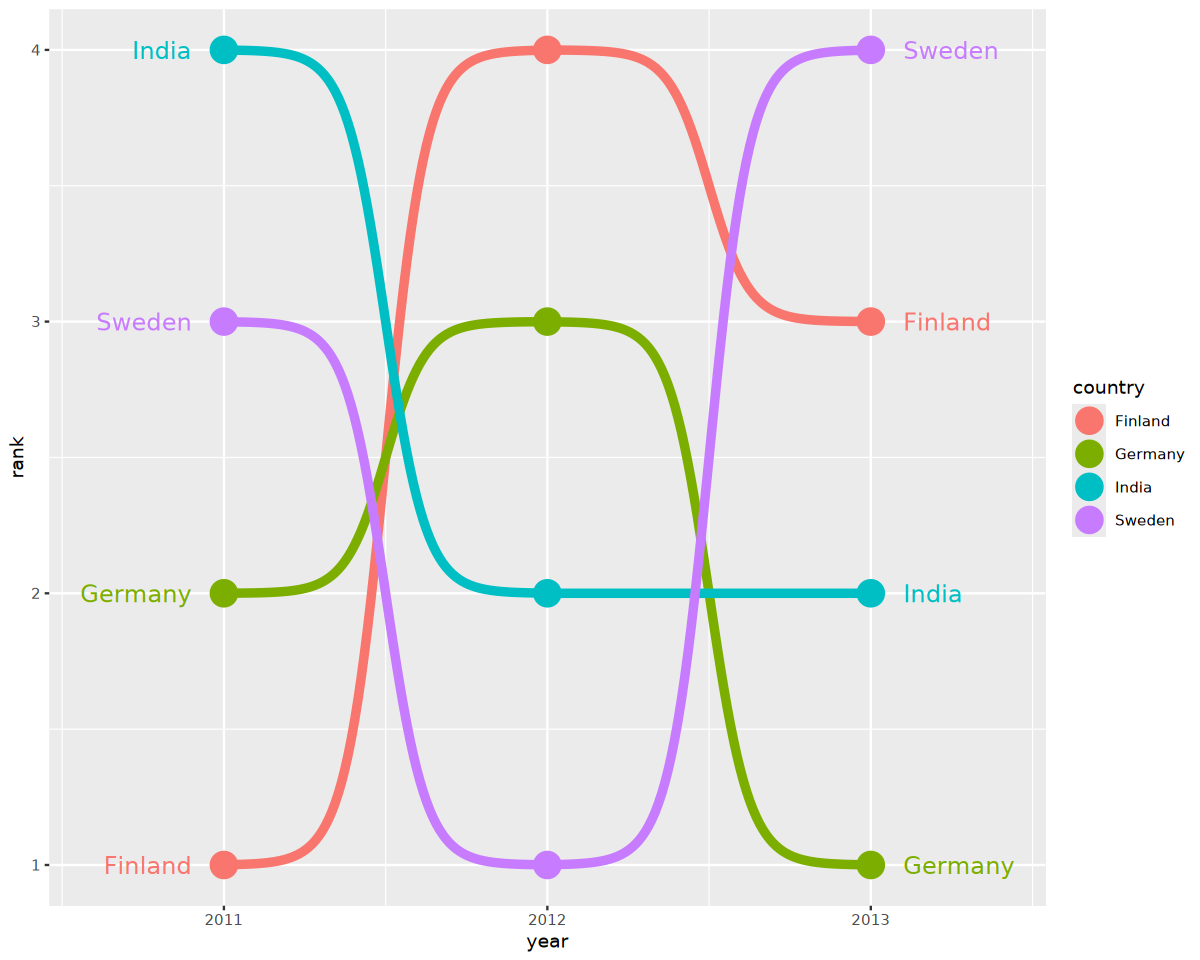

In [362]:
ggplot(df.country, aes(year, rank, color = country)) +
  geom_point(size = 7) +
  geom_bump(size = 2, smooth = 8)  +
  geom_text(data = df.country %>% filter(year == min(year)),
            aes(x = year - .1, label = country), size = 5, hjust = 1)+
  geom_text(data = df.country %>% filter(year == max(year)),
            aes(x = year + .1, label = country), size = 5, hjust = 0)+
  scale_x_continuous(limits = c(2010.6, 2013.4),
                     breaks = seq(2011, 2013, 1)) 

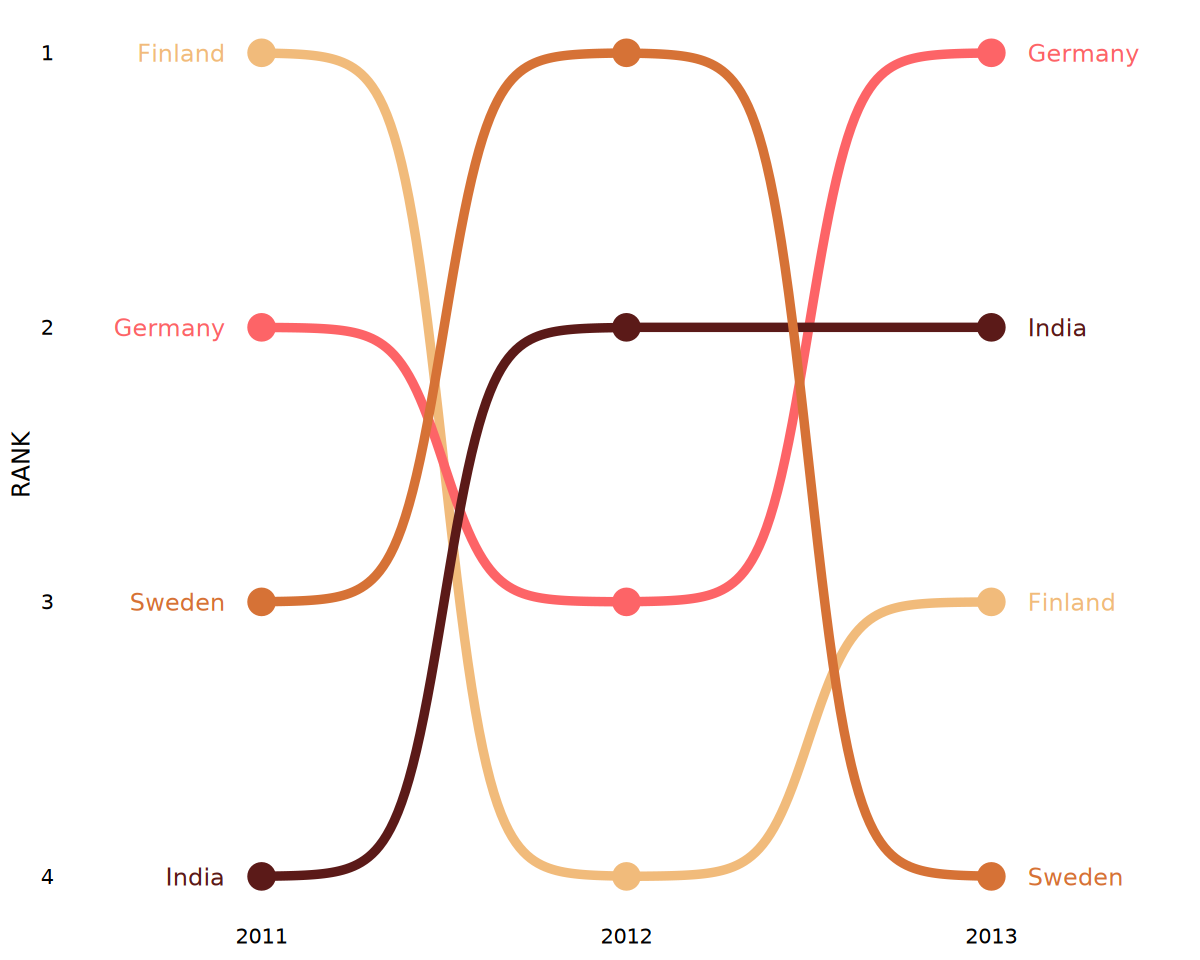

In [325]:
ggplot(df.country, aes(year, rank, color = country)) +
  geom_point(size = 7) +
  geom_text(data = df.country %>% filter(year == min(year)),
            aes(x = year - .1, label = country), size = 5, hjust = 1) +
  geom_text(data = df.country %>% filter(year == max(year)),
            aes(x = year + .1, label = country), size = 5, hjust = 0) +
  geom_bump(size = 2, smooth = 8) +
  scale_x_continuous(limits = c(2010.6, 2013.4),
                     breaks = seq(2011, 2013, 1)) +
  theme_minimal_grid(font_size = 14, line_size = 0) +
  theme(legend.position = "none",
        panel.grid.major = element_blank()) +
  labs(y = "RANK",
       x = NULL) +
  scale_y_reverse() +
  scale_color_manual(values = wes_palette(n = 4, name = "GrandBudapest1"))

In [64]:
xmap_ref <-
  tibble::tribble(~key1, ~key2, ~weight,
                  "a", "a", 1,
                  "b", "b", 1,
                  "c", "other", 1,
                  "d", "other", 1)

In [76]:
data.frame(x = 1:10) |> 
  transform(y = x * 2) |> 
  subset(y > 10)

,x,y
,<int>,<dbl>
6,6,12
7,7,14
8,8,16
9,9,18
10,10,20


In [56]:
df_x <- tibble(
  yend = 3,
  y = 1:5,
  xend = 3,
  x = 0,
  group = c("Flour", "Milk", "Eggs", "Salt", "Butter")
)

In [61]:
df_x 

yend,y,xend,x,group
<dbl>,<int>,<dbl>,<dbl>,<chr>
3,1,3,0,Flour
3,2,3,0,Milk
3,3,3,0,Eggs
3,4,3,0,Salt
3,5,3,0,Butter


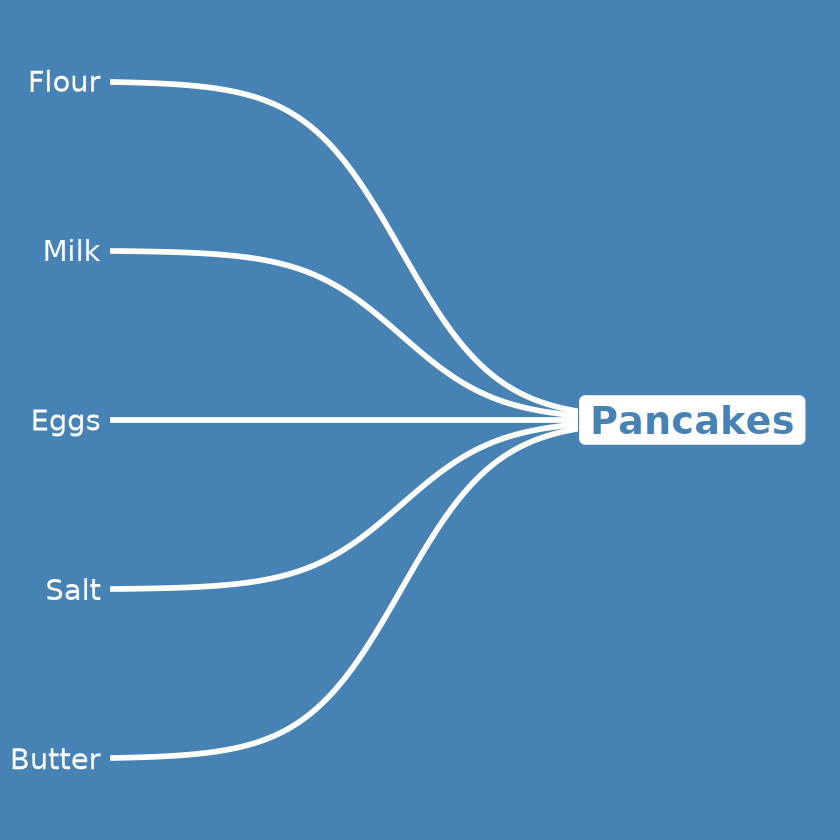

In [60]:
ggplot(df_x) +
  geom_sigmoid(aes(x = x, y = y, xend = xend, yend = yend, group = factor(group)),
               direction = "x", color = "white", linewidth = 1.2, smooth = 6) +
  geom_text(aes(x = x, y = y, label = group), size = 6, nudge_x = -.05, color = "white", hjust = 1) +
  geom_label(data = tibble(x = 3, y = 3, label = "Pancakes"), 
             aes(x, y, label = label), inherit.aes = F, size = 8, color = "steelblue", fill = "white", fontface = "bold") +
  coord_cartesian(clip = "off") +
  scale_y_reverse() +
  theme_void() +
  theme(panel.background = element_rect(fill = "steelblue", color = "transparent"),
        plot.background = element_rect(fill = "steelblue", color = "transparent"),
        plot.margin = margin(1, 2.5, 1, 1.5, "cm"))

In [217]:
vaccinations %>% head

,survey,freq,subject,response,start_date,end_date
,<fct>,<int>,<int>,<fct>,<date>,<date>
1,ms153_NSA,48,1,Always,2010-09-22,2010-10-25
2,ms153_NSA,9,2,Always,2010-09-22,2010-10-25
3,ms153_NSA,66,3,Always,2010-09-22,2010-10-25
4,ms153_NSA,1,4,Always,2010-09-22,2010-10-25
5,ms153_NSA,11,5,Always,2010-09-22,2010-10-25
6,ms153_NSA,1,6,Always,2010-09-22,2010-10-25


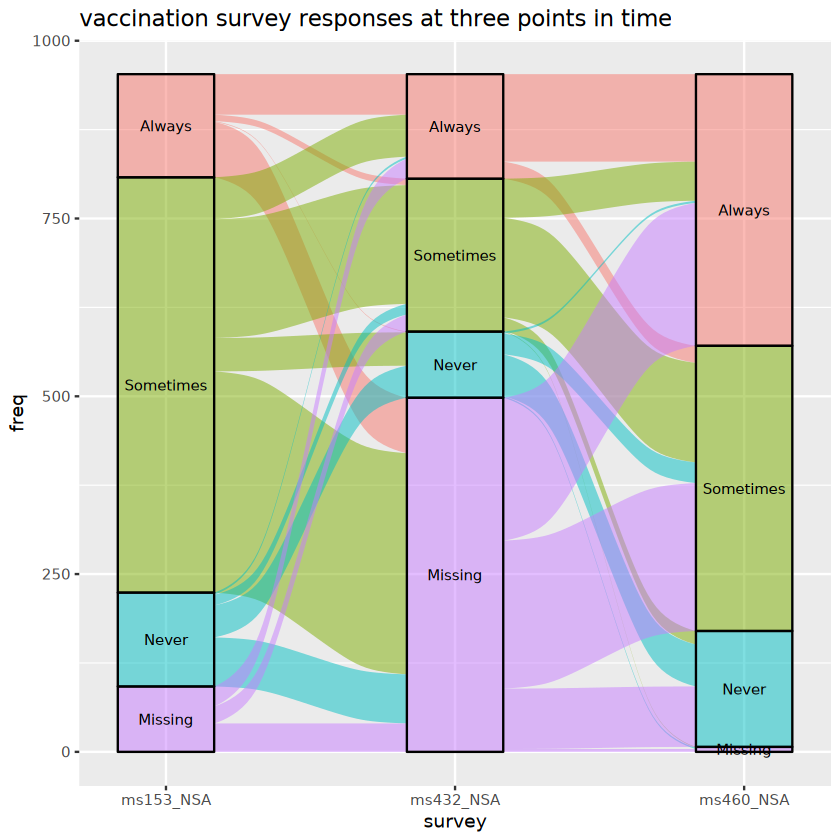

In [44]:
ggplot(vaccinations,
       aes(x = survey, stratum = response, alluvium = subject,
           y = freq,
           fill = response, label = response)) +
  scale_x_discrete(expand = c(.1, .1)) +
  geom_flow() +
  geom_stratum(alpha = .5) +
  geom_text(stat = "stratum", size = 3) +
  theme(legend.position = "none") +
  ggtitle("vaccination survey responses at three points in time")

In [220]:
tmp.subset = tmp.subset |> mutate(freq = 1)

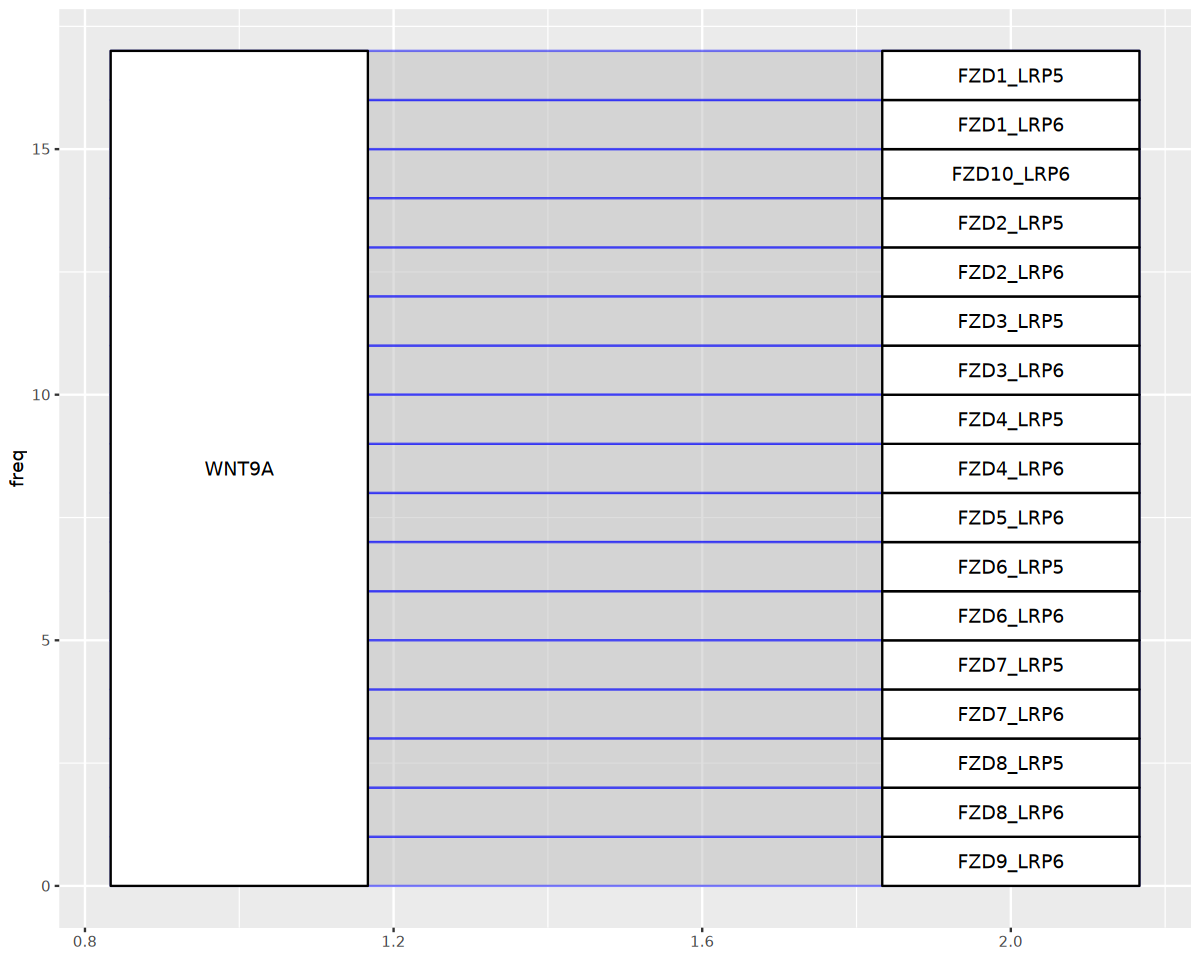

In [223]:
ggplot(tmp.subset, aes(axis1 = ligand, axis2 = receptor, y = freq)) +
  geom_alluvium(curve_type = "linear", colour = "blue") +
  geom_stratum() +
  geom_text(stat = "stratum", aes(label = paste(after_stat(stratum))))

In [229]:
library(ggsankey)

In [233]:
long.table = tmp.subset %>% select(ligand, receptor, copula_coeff) %>% make_long(ligand, receptor, value= copula_coeff)

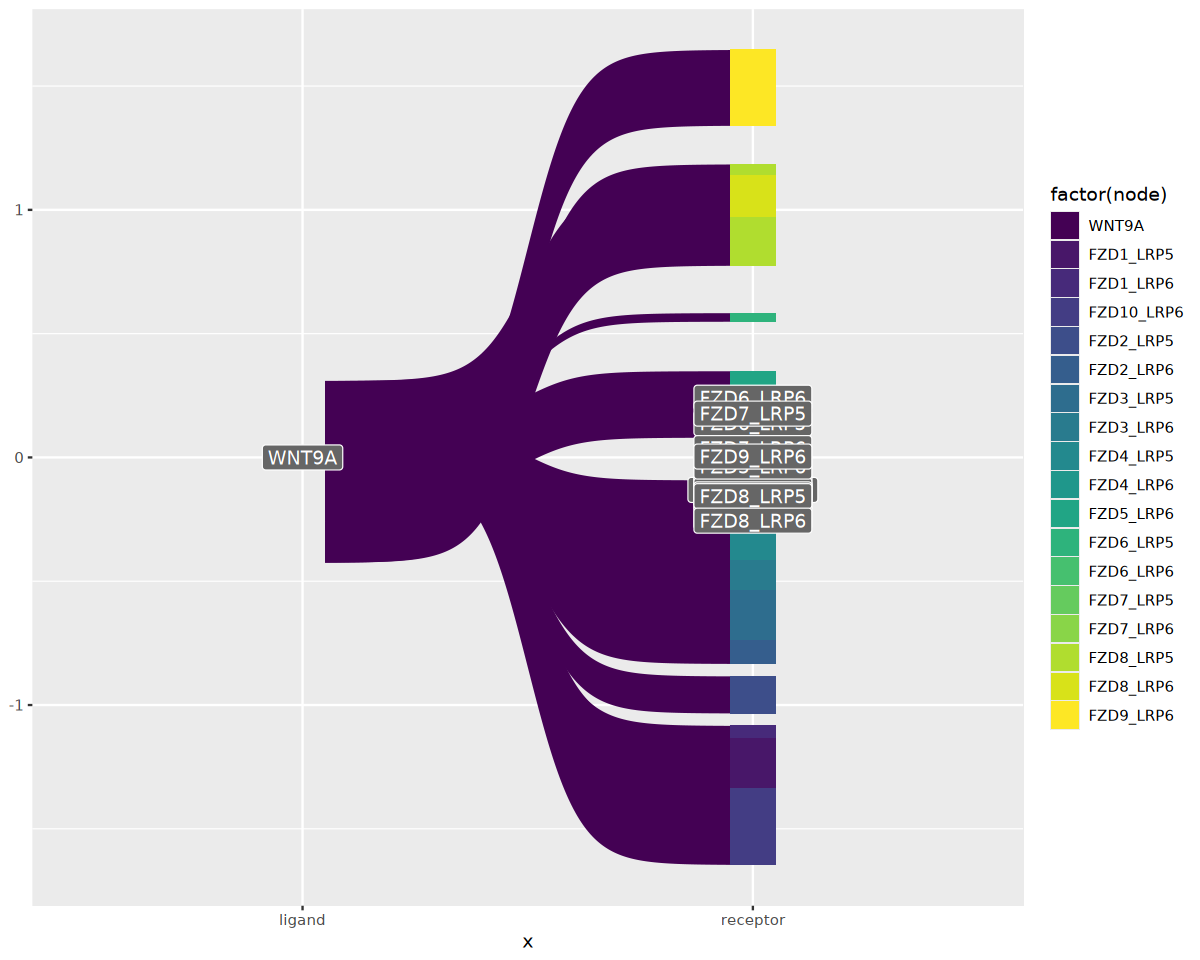

In [234]:
long.table %>% ggplot(., aes(x = x,
                next_x = next_x,
                node = node,
                next_node = next_node,
                fill = factor(node),
                label = node,
                value = value
                )) +
  geom_sankey(space = 0.2) +
  geom_sankey_label(color = "white", fill = "gray40") +
  scale_fill_viridis_d()